# Deep Learning with PyTorch : Build a Generative Adversarial Network

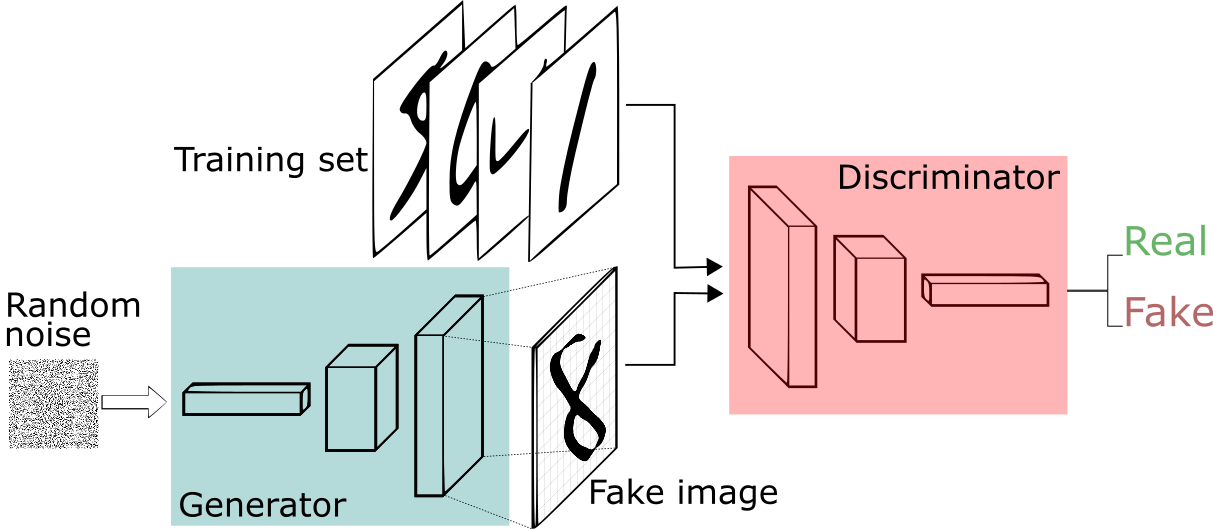

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

epochs = 20

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([T.RandomRotation([-20,+20]), T.ToTensor()])

In [5]:
trainset = datasets.MNIST('MNIST/', download =True, train = True, transform= train_augs)

100%|██████████| 9912422/9912422 [00:01<00:00, 5964030.70it/s]


Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 35357762.35it/s]


Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5922437.96it/s]


Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3861071.90it/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw



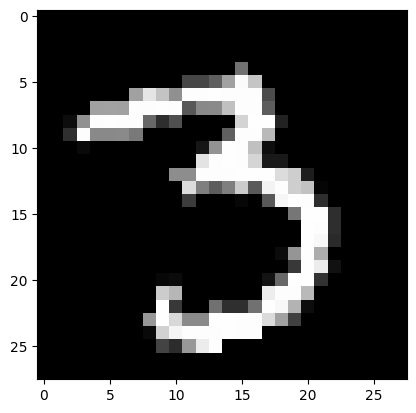

In [6]:
image, label = trainset[9053]
plt.imshow(image.squeeze(), cmap = 'gray')

In [7]:
print(" total img present in dataset^ ", len(trainset))

 total img present in dataset^  60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [10]:
print(" Total no. of batches in trainloader ^", len(trainloader))
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

 Total no. of batches in trainloader ^ 469
torch.Size([128, 1, 28, 28])


In [11]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

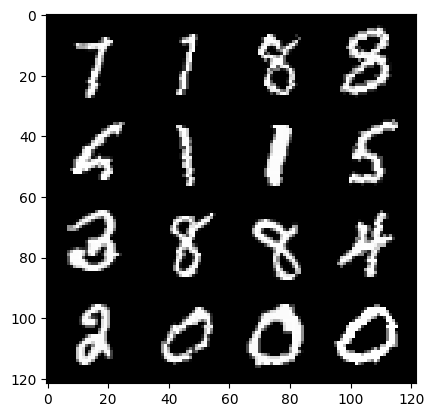

In [12]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [13]:
#In case if torch summary is not installed

!pip install torchsummary


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from torch import nn
from torchsummary import summary

In [15]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [16]:
def get_discriminator_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
  nn.BatchNorm2d(out_channels),
  nn.LeakyReLU(0.2)
  )

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()

     self.block_1 =get_discriminator_block(1,16,(3,3),2)
     self.block_2 =get_discriminator_block(16,32,(5,5),2)
     self.block_3 =get_discriminator_block(32,64,(5,5),2)

     self.flatten = nn.Flatten()
     self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    x1 =self.block_1(images)
    x2 =self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [18]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

AssertionError: Torch not compiled with CUDA enabled

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()

    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64,1,(4,4),2, final_block=True)

  def forward(self, r_noise_vec):

    x=r_noise_vec.view(-1, self.noise_dim,1,1)

    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)

    return x4


In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)

G = G.apply(weights_init)


# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss=criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss=criterion(disc_pred, ground_truth)
  return loss


In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6837188747645949 0.6930278890422666


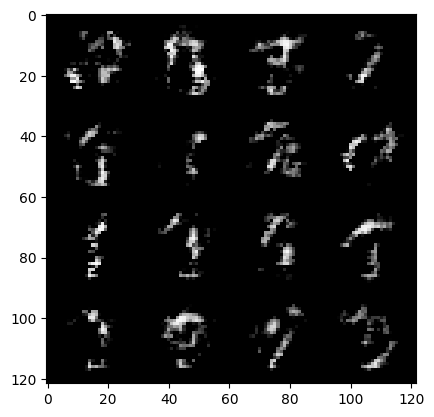

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.676327749228935 0.714258566594073


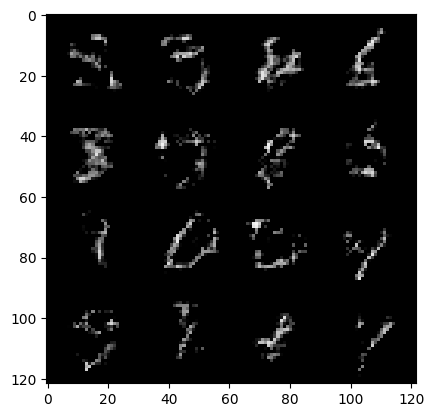

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6274876980893394 0.7664830593157933


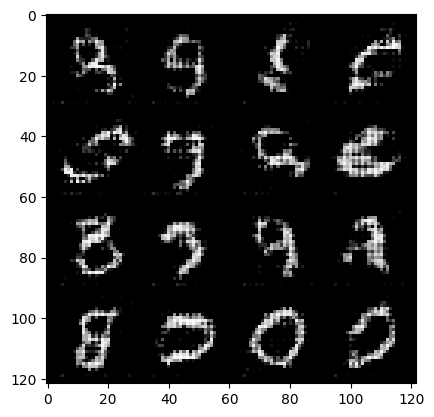

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.5939751808831433 0.8140274161723122


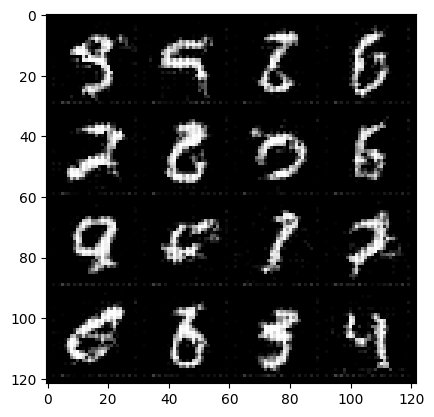

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.5848443159924895 0.8413365583684145


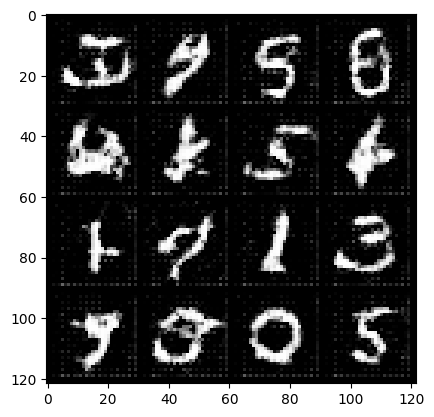

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.5776424995109216 0.8666978681773774


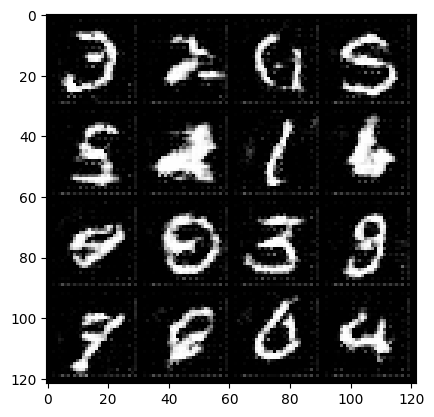

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.5921404721386143 0.8615827015213875


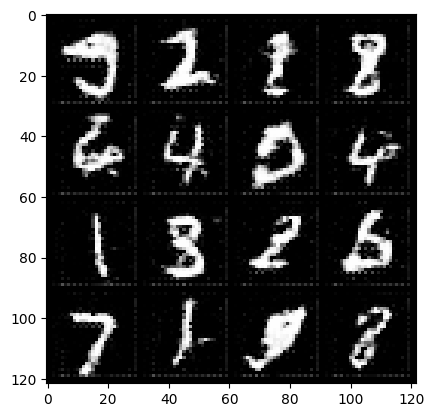

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.605657978606885 0.8495905026952341


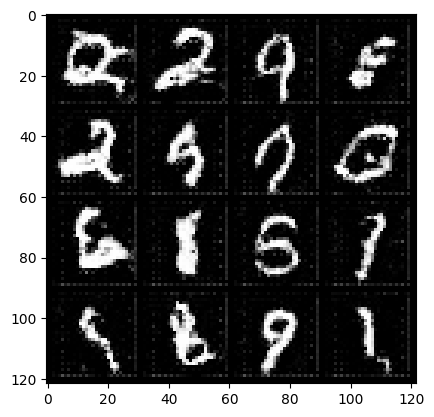

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6180455779978461 0.8403535724194573


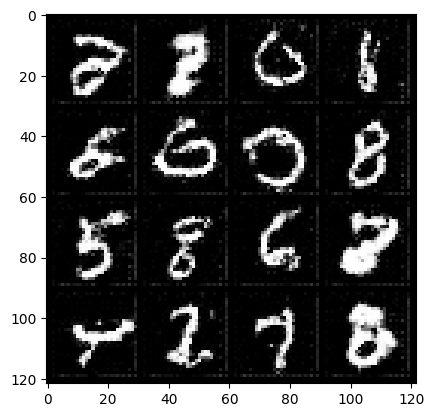

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6227759440570498 0.8389470255705339


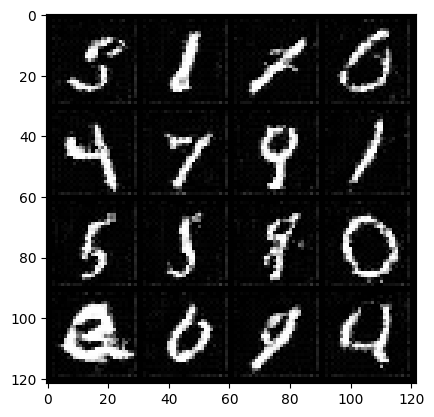

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6128535456240558 0.8577612109784124


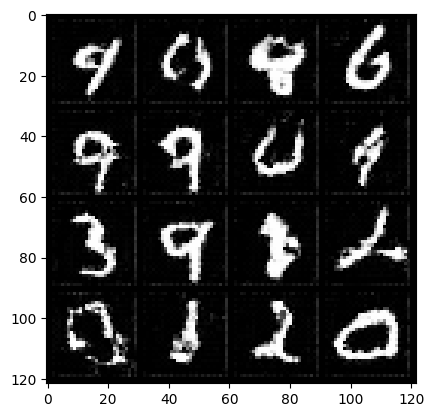

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6056539882729048 0.87191051320989


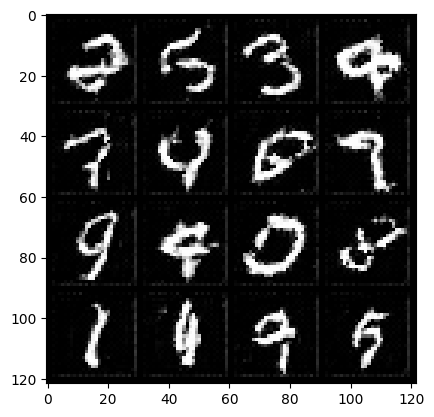

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6083516897931536 0.8735156908218287


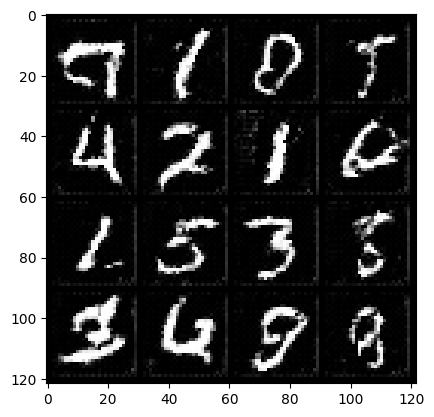

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6088173976585046 0.8733029436709275


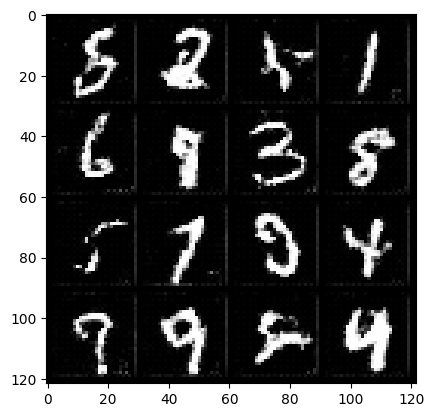

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6098225252714746 0.8795896093728446


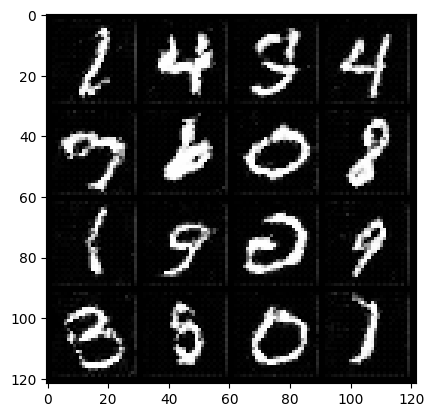

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6117723308392425 0.8799155105405779


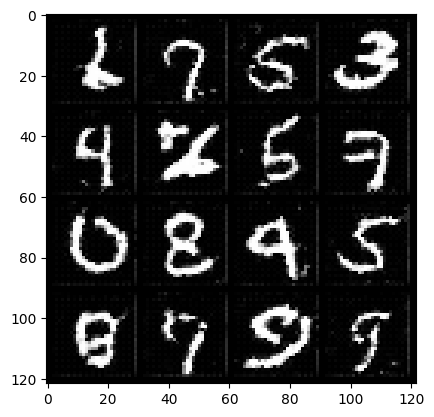

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6154617956960633 0.8768463793085582


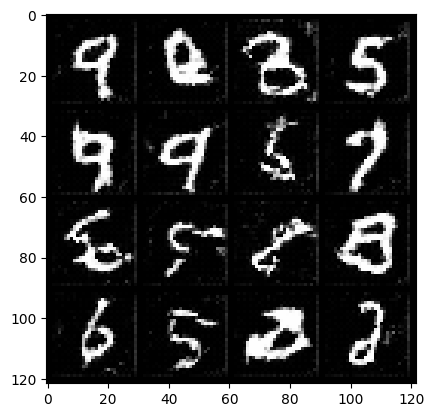

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6175916736314038 0.8703625316558871


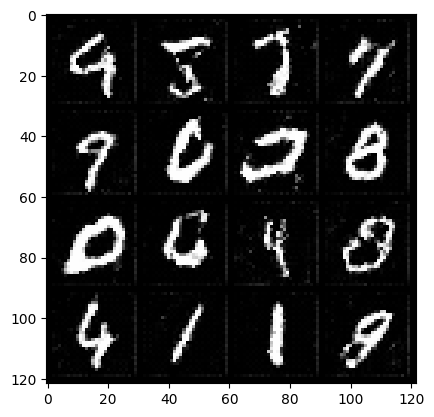

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6208285773232547 0.8718835054430117


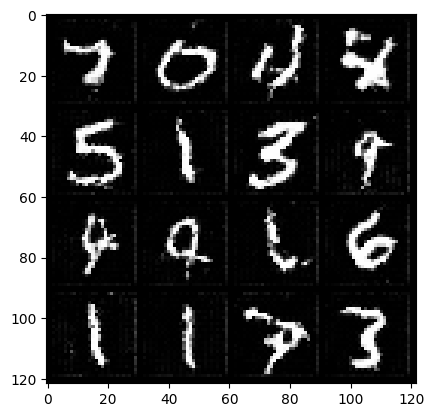

  0%|          | 0/469 [00:00<?, ?it/s]

losses d, g 0.6242076959182967 0.8635503287508544


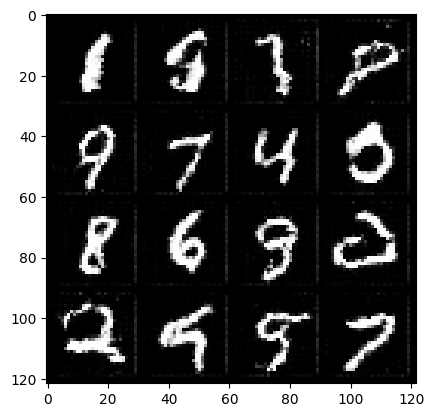

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device= device)

    fake_img = G(noise)

    D_pred = D(fake_img)

    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)
  print("losses d, g", avg_d_loss, avg_g_loss)

  show_tensor_images(fake_img)

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya